# Community Health evaluation - QOL Prediction XGB-DT

## Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ziya07/community-health-evaluation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ziya07/community-health-evaluation-dataset/versions/1


## Import dependencies

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

2024-10-25 01:15:09.073993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 01:15:09.116700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 01:15:09.141458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 01:15:09.149401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 01:15:09.182924: I tensorflow/core/platform/cpu_feature_guar

## Read df

In [3]:
df = pd.read_csv(path + "/community_health_evaluation_dataset.csv")

In [4]:
df.head()

,Participant ID,Age,Gender,SES,Service Type,Visit Frequency,Step Frequency (steps/min),Stride Length (m),Joint Angle (°),EMG Activity,Patient Satisfaction (1-10),Quality of Life Score
0,1,56,F,4,Rehab,Weekly,85,0.54,17.99,Low,1,57
1,2,69,M,1,Preventive,Yearly,80,0.70,13.05,Moderate,8,94
2,3,46,M,4,Rehab,Yearly,81,0.57,29.85,Moderate,4,66
3,4,32,F,1,Consultation,Weekly,66,0.78,28.54,Moderate,9,66
4,5,60,M,3,Preventive,Weekly,73,0.84,20.80,High,5,98


## Getting columns and encoding

In [5]:
df_oi = df.drop('Participant ID', axis=1)

columns_to_encode = df_oi.select_dtypes(include='object').columns

for column in columns_to_encode:
    le = LabelEncoder()
    df_oi[column] = le.fit_transform(df_oi[column])


## Correlation Matrix

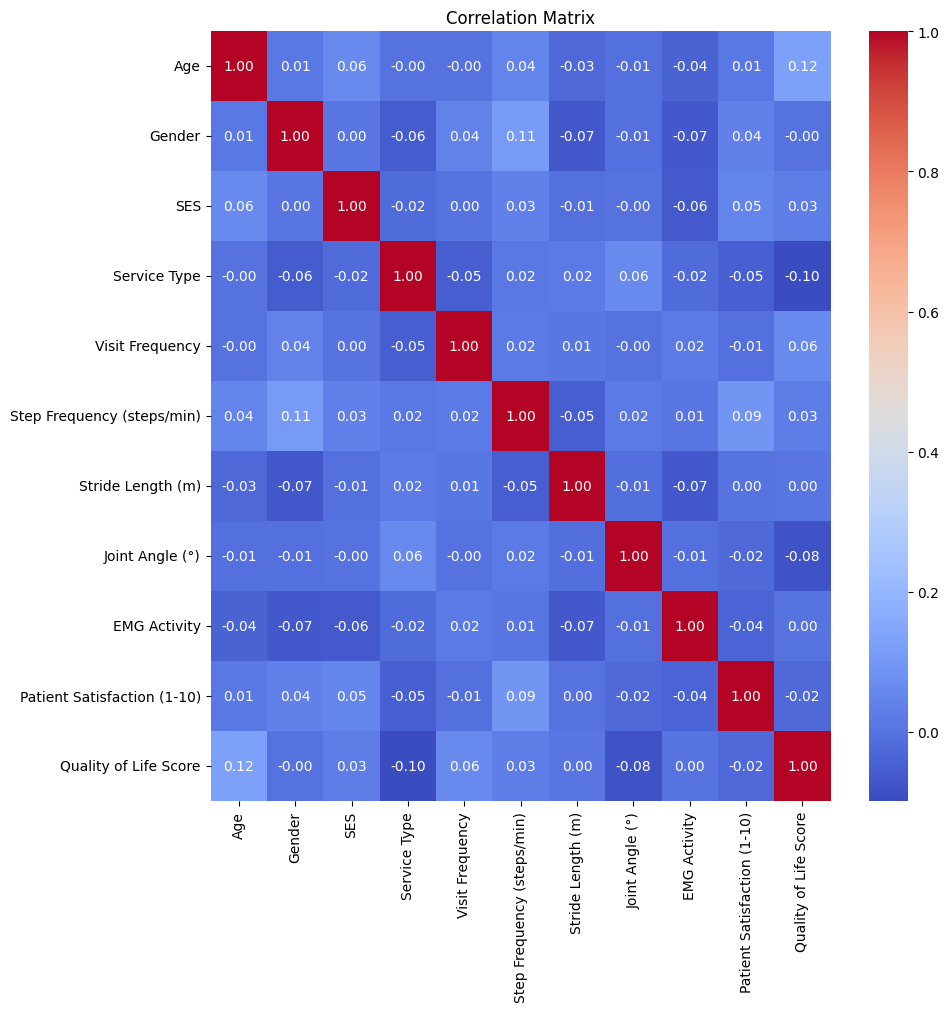

In [6]:
correlation = df_oi.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Distribution between Age and QOL

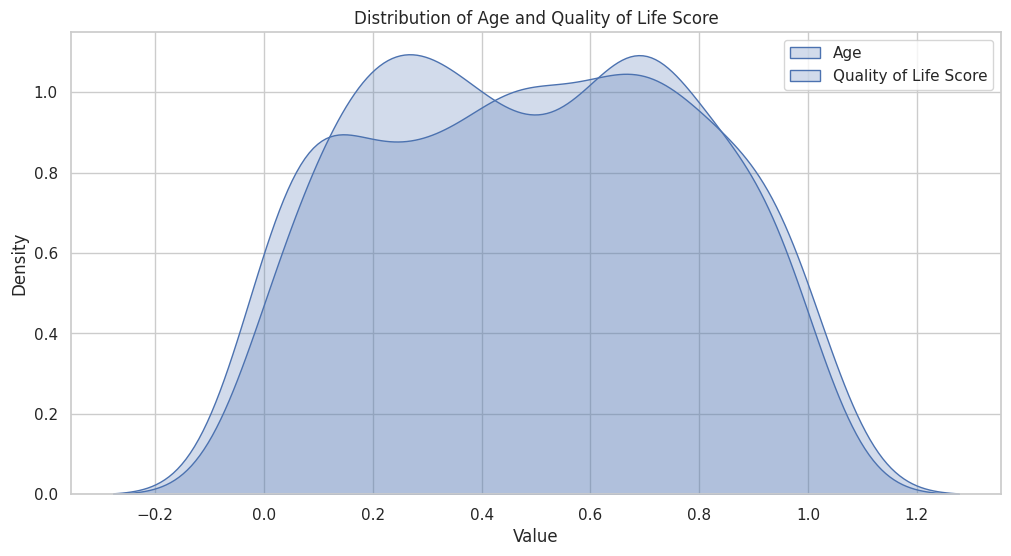

In [39]:
plt.figure(figsize=(12, 6))

minmax_scaler = MinMaxScaler()

age = minmax_scaler.fit_transform(df_oi['Age'].values.reshape(-1, 1))
quality_of_life_score = minmax_scaler.fit_transform(df_oi['Quality of Life Score'].values.reshape(-1, 1))

sns.kdeplot(age, shade=True, label='Age')
sns.kdeplot(quality_of_life_score, shade=True, label='Quality of Life Score')

plt.title('Distribution of Age and Quality of Life Score')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

## Linear Regression Analysis

In [7]:
# Define the independent variables (all columns except 'Quality of Life Score')
X = df_oi.drop('Quality of Life Score', axis=1)

y = df_oi['Quality of Life Score']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Print the coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

                             Coefficient
Age                             0.112809
Gender                         -0.405729
SES                             0.221976
Service Type                   -1.621343
Visit Frequency                 0.967377
Step Frequency (steps/min)      0.034780
Stride Length (m)               0.898010
Joint Angle (°)                -0.177455
EMG Activity                    0.038843
Patient Satisfaction (1-10)    -0.162709


In [8]:
# Adding a constant for statsmodels
X = sm.add_constant(X)

# Fit the model using statsmodels for detailed summary
model_sm = sm.OLS(y, X).fit()
print(model_sm.summary())

                              OLS Regression Results                             
Dep. Variable:     Quality of Life Score   R-squared:                       0.036
Model:                               OLS   Adj. R-squared:                  0.007
Method:                    Least Squares   F-statistic:                     1.259
Date:                   Fri, 25 Oct 2024   Prob (F-statistic):              0.253
Time:                           01:15:11   Log-Likelihood:                -1400.0
No. Observations:                    347   AIC:                             2822.
Df Residuals:                        336   BIC:                             2864.
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

## Classification Model

We will use the 6 more correlated variables with QOL to make the model

### Defining X and y

In [9]:
X = df_oi.drop('Quality of Life Score', axis=1)
# Define the dependent variable
y = df_oi['Quality of Life Score']

# This is because the quality of life score starts from 50
y=y-50

### Train Test Split

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Defining the XGB Model

In [11]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000, 2000],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 12],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

# Initialize RandomizedSearchCV with the XGBoost model
random_search = RandomizedSearchCV(estimator=XGBClassifier(objective='multi:softmax', num_class=50, eval_metric='mlogloss'),
                                   param_distributions=param_grid,
                                   n_iter=100,  # Number of parameter settings that are sampled
                                   scoring='accuracy',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

print("Best parameters found: ", best_params)

# Make predictions
y_pred = best_xgb_model.predict(X_test)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'subsample': 1, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


### XGB Model Error mean

In [12]:
# Calculate the error
error = y_test - y_pred
# Display the error
print("Error between actual and predicted values:")
print(error.mean())

Error between actual and predicted values:
2.3142857142857145


## Decision Tree Model

In [13]:
from skopt import BayesSearchCV

# Define the parameter grid for Bayesian optimization
param_grid_bayes = {
    'criterion': ['gini', 'entropy'],
    'max_depth': (1, 50),
    'min_samples_split': (2, 15),
    'min_samples_leaf': (1, 15)
}

# Initialize BayesSearchCV with the DecisionTreeClassifier
bayes_search = BayesSearchCV(estimator=DecisionTreeClassifier(),
                             search_spaces=param_grid_bayes,
                             scoring='accuracy',
                             cv=3,
                             n_jobs=-1,
                             n_iter=32,
                             verbose=1,
                             random_state=42)

# Fit BayesSearchCV
bayes_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params_bayes = bayes_search.best_params_
best_dt_model_bayes = bayes_search.best_estimator_

print("Best parameters found: ", best_params_bayes)

# Make predictions
y_pred_dt_bayes = best_dt_model_bayes.predict(X_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [14]:
# Calculate the error
error = y_test - y_pred_dt_bayes
# Display the error
print("Error between actual and predicted values:")
print(error.mean())

Error between actual and predicted values:
7.171428571428572


## Predictions versus Real QOL

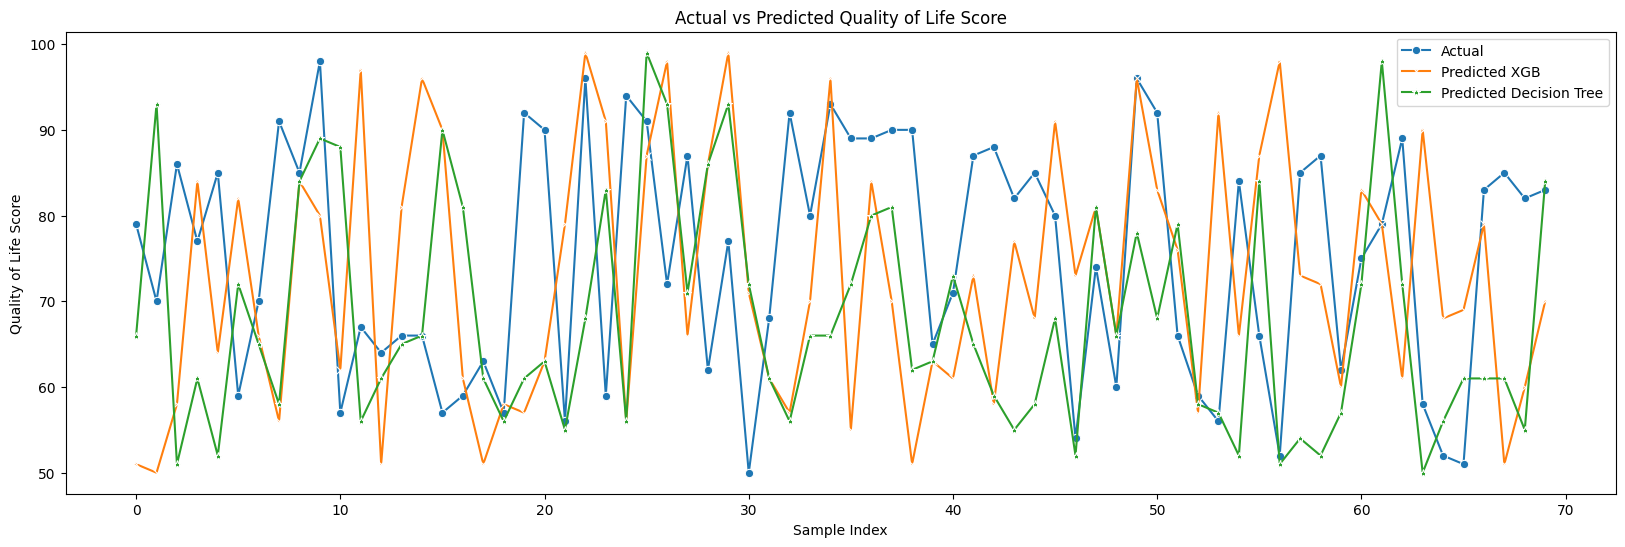

In [16]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=range(len(y_test)), y=(y_test+50), label='Actual', marker='o')
sns.lineplot(x=range(len(y_test)), y=(y_pred+50), label='Predicted XGB', marker='x')
sns.lineplot(x=range(len(y_test)), y=(y_pred_dt_bayes+50), label='Predicted Decision Tree', marker='*')
plt.xlabel('Sample Index')
plt.ylabel('Quality of Life Score')
plt.title('Actual vs Predicted Quality of Life Score')
plt.legend()
plt.show()